 Dataset split: Train=3241, Val=694, Test=695
Epoch 1/2, Train=594.7057
Epoch 2/2, Train=357.0684
Using cpu device
---------------------------
| time/              |    |
|    fps             | 62 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 50 |
---------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 56            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 100           |
| train/                  |               |
|    approx_kl            | 0.00022060276 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.32         |
|    explained_variance   | 0.207         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0105       |
|    n_updates            | 10            |
|    policy_gradient_loss | -

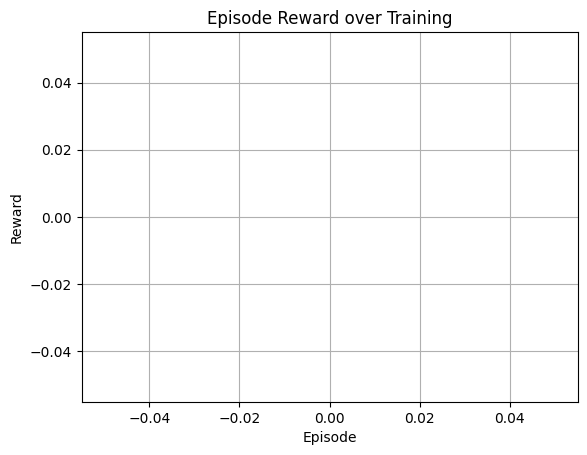

Total sampled points after eval = 6


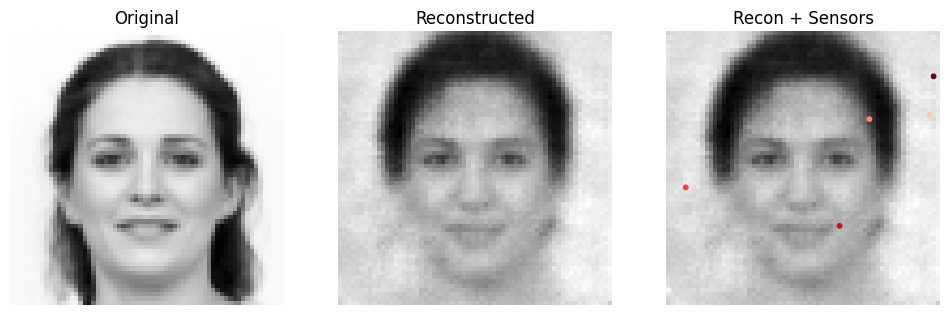

 Dataset split: Train=3241, Val=694, Test=695
Epoch 1/2, Train=595.4571
Epoch 2/2, Train=359.0955
Using cpu device
---------------------------
| time/              |    |
|    fps             | 65 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 50 |
---------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 59            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 100           |
| train/                  |               |
|    approx_kl            | 0.00018514633 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.32         |
|    explained_variance   | 0.323         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.0255        |
|    n_updates            | 10            |
|    policy_gradient_loss | -

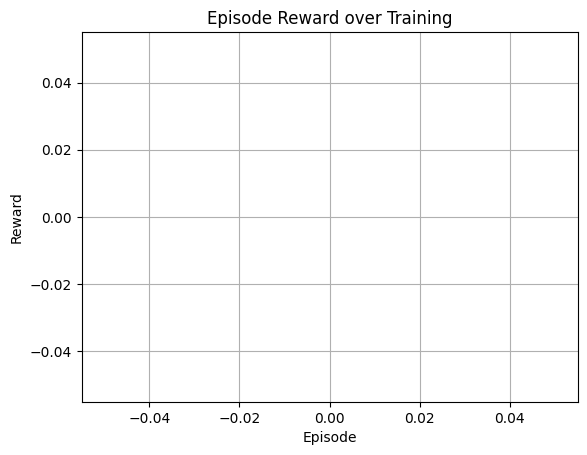

Total sampled points after eval = 6


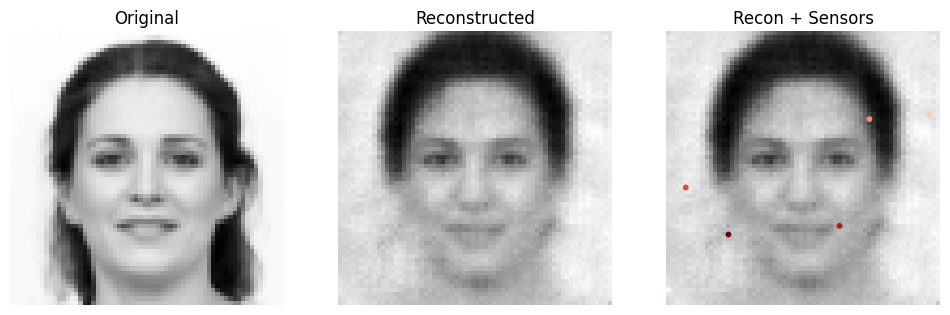

In [20]:
# ============================================================
# Adaptive Compressed Sensing with VAE + Stable-Baselines3 PPO
# ============================================================

import os, glob, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image# ============================================================
# Adaptive Compressed Sensing with VAE + Stable-Baselines3 PPO
# ============================================================

import os, glob, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# ------------------------------
# Config
# ------------------------------
config = {
    "image_size": 64,
    "latent_dim": 64,
    "ae_epochs": 2,                       # quick test
    "ppo_steps": 2000,                    # total timesteps for PPO (>= adaptive_steps * episodes)
    "probe_points": 5,
    "adaptive_steps": 50,                 # episode length
    "reward_type": "episodic", 
    "reward_alpha": 50.0,
    "reward_lambda": 0.5,
    "use_perceptual_loss": False,
    "lr_vae": 1e-3,
    "lr_ppo": 1e-4,
    "seed": 42,
    "data_dir": "data/faces/ai/",
    "batch_size": 32,
}

torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# Dataset
# ------------------------------
class FaceDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = glob.glob(os.path.join(folder, "**", "*.jpg"), recursive=True) + \
                     glob.glob(os.path.join(folder, "**", "*.png"), recursive=True)
        if len(self.files) == 0:
            raise RuntimeError(f"No images found in {folder}")
        self.transform = transform
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        if self.transform: img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
dataset = FaceDataset(config["data_dir"], transform=transform)
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
val_loader   = DataLoader(val_set, batch_size=config["batch_size"], shuffle=False)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)
print(f" Dataset split: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")

# ------------------------------
# VAE
# ------------------------------
class ConvVAEGray(nn.Module):
    def __init__(self, latent_dim=32, img_size=64):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        flat_dim = (img_size//8)**2 * 128
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1), nn.Sigmoid()
        )
        self.img_size = img_size
    def encode(self, x):
        h = self.enc_conv(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar); eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, self.img_size//8, self.img_size//8)
        return self.dec_conv(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_fn(recon_x, x, mu, logvar):
    recon_loss = F.l1_loss(recon_x, x, reduction="sum")
    if config["use_perceptual_loss"]:
        recon_loss += 0.1 * (1 - ssim(
            x.squeeze().cpu().numpy(), 
            recon_x.squeeze().detach().cpu().numpy(), 
            data_range=1.0
        ))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)

def train_vae(model, train_loader, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train(); train_loss=0
        for imgs in train_loader:
            imgs=imgs.to(device); optimizer.zero_grad()
            recon, mu, logvar = model(imgs)
            loss = vae_loss_fn(recon, imgs, mu, logvar)
            loss.backward(); optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train={train_loss/len(train_loader):.4f}")

vae = ConvVAEGray(latent_dim=config["latent_dim"], img_size=config["image_size"]).to(DEVICE)
opt_vae = optim.Adam(vae.parameters(), lr=config["lr_vae"])
train_vae(vae, train_loader, opt_vae, config["ae_epochs"], DEVICE)

# ------------------------------
# Gym Environment
# ------------------------------
class AdaptiveSensingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}
    def __init__(self, vae, img, config):
        super().__init__()
        self.vae = vae
        self.img = img.clone().detach()
        self.H, self.W = config["image_size"], config["image_size"]
        self.n_pixels = self.H * self.W
        self.max_steps = config["adaptive_steps"]
        self.config = config

        self.action_space = spaces.Discrete(self.n_pixels)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.H, self.W, 2), dtype=np.float32
        )

    def reset(self):
        self.sampled = list(map(int, torch.randperm(self.n_pixels)[:self.config["probe_points"]].cpu().numpy()))
        self.z = torch.randn(1, self.config["latent_dim"], device=self.img.device, requires_grad=True)
        self.opt_z = torch.optim.Adam([self.z], lr=1e-2)
        self.recon = self._latent_optimize(steps=30)
        self.prev_error = self._compute_error(self.recon)
        self.steps = 0
        return self._get_state()

    def step(self, action):
        action = int(action)
        if action in self.sampled:
            return self._get_state(), -0.1, False, {}
        self.sampled.append(action)
        self.steps += 1
        self.recon = self._latent_optimize(steps=10)
        error = self._compute_error(self.recon)
        reward = self._compute_reward(self.prev_error, error)
        self.prev_error = error
        done = (self.steps == self.max_steps)   # episode ends exactly at adaptive_steps
        return self._get_state(), reward, done, {}

    def _latent_optimize(self, steps=10):
        idx = torch.tensor(self.sampled, device=self.img.device)
        y = self.img.view(-1)[idx]
        for _ in range(steps):
            self.opt_z.zero_grad()
            recon = self.vae.decode(self.z).view(-1)
            loss = F.mse_loss(recon[idx], y)
            loss.backward()
            self.opt_z.step()
        with torch.no_grad():
            return self.vae.decode(self.z).view(1, 1, self.H, self.W)

    def _compute_error(self, recon): 
        return F.mse_loss(recon, self.img).item()

    def _compute_reward(self, prev_error, error):
        if self.config["reward_type"] == "absolute":
            return -error
        elif self.config["reward_type"] == "improvement":
            return prev_error - error
        elif self.config["reward_type"] == "exp":
            return math.exp(-self.config["reward_alpha"] * error)
        elif self.config["reward_type"] == "hybrid":
            return (prev_error - error) - self.config["reward_lambda"] * error
        elif self.config["reward_type"] == "episodic":
            return -error if self.steps == self.max_steps else 0
        else:
            return prev_error - error

    def _get_state(self):
        mask = torch.zeros_like(self.img)
        mask.view(-1)[self.sampled] = 1.0
        state = torch.cat([self.recon, mask], dim=1).squeeze(0)  # (2,H,W)
        state = state.permute(1, 2, 0).cpu().numpy()             # (H,W,2)
        return state.astype(np.float32)

    def render(self, mode="human"):
        orig=self.img.squeeze().cpu().numpy()
        recon=self.recon.squeeze().cpu().numpy()
        coords=[(i//self.W,i%self.W) for i in self.sampled]
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(orig,cmap="gray"); plt.axis("off"); plt.title("Original")
        plt.subplot(1,3,2); plt.imshow(recon,cmap="gray"); plt.axis("off"); plt.title("Reconstructed")
        plt.subplot(1,3,3); plt.imshow(recon,cmap="gray")
        if coords:
            ys,xs=zip(*coords); colors=np.linspace(0.3,1.0,len(coords))
            plt.scatter(xs,ys,c=colors,cmap="Reds",s=10,marker="o")
        plt.axis("off"); plt.title("Recon + Sensors"); plt.show()

# ------------------------------
# Reward logger callback
# ------------------------------
class RewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
        return True

# ------------------------------
# Training and evaluation
# ------------------------------
test_img = next(iter(test_loader))[0].unsqueeze(0).to(DEVICE)

def make_env():
    return AdaptiveSensingEnv(vae, test_img, config)

env = DummyVecEnv([make_env])

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=config["lr_ppo"],
    n_steps=config["adaptive_steps"],  # rollout = episode length
    batch_size=config["adaptive_steps"],
    device="cpu",  # PPO + MLP runs better on CPU
)

reward_logger = RewardLogger()
model.learn(total_timesteps=config["ppo_steps"], callback=reward_logger)

# Plot reward curve
plt.figure()
plt.plot(reward_logger.episode_rewards, marker="o")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Reward over Training")
plt.grid(True)
plt.show()

# Final evaluation rollout
env_eval = AdaptiveSensingEnv(vae, test_img, config)
obs = env_eval.reset()
done = False
steps = 0
while not done and steps < config["adaptive_steps"]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_eval.step(action)
    steps += 1
print(f"Total sampled points after eval = {len(env_eval.sampled)}")
env_eval.render()

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# ------------------------------
# Config
# ------------------------------
config = {
    "image_size": 64,
    "latent_dim": 64,
    "ae_epochs": 2,         # keep small for quick test
    "ppo_steps": 2000,      # total timesteps for PPO
    "probe_points": 5,
    "adaptive_steps": 50,   # episode length
    "reward_type": "episodic", 
    "reward_alpha": 50.0,
    "reward_lambda": 0.5,
    "use_perceptual_loss": False,
    "lr_vae": 1e-3,
    "lr_ppo": 1e-4,
    "seed": 42,
    "data_dir": "data/faces/ai/",
    "batch_size": 32,
}

torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# Dataset
# ------------------------------
class FaceDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = glob.glob(os.path.join(folder, "**", "*.jpg"), recursive=True) + \
                     glob.glob(os.path.join(folder, "**", "*.png"), recursive=True)
        if len(self.files) == 0:
            raise RuntimeError(f"No images found in {folder}")
        self.transform = transform
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        if self.transform: img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
dataset = FaceDataset(config["data_dir"], transform=transform)
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
val_loader   = DataLoader(val_set, batch_size=config["batch_size"], shuffle=False)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)
print(f" Dataset split: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")

# ------------------------------
# VAE
# ------------------------------
class ConvVAEGray(nn.Module):
    def __init__(self, latent_dim=32, img_size=64):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        flat_dim = (img_size//8)**2 * 128
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1), nn.Sigmoid()
        )
        self.img_size = img_size
    def encode(self, x):
        h = self.enc_conv(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar); eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, self.img_size//8, self.img_size//8)
        return self.dec_conv(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_fn(recon_x, x, mu, logvar):
    recon_loss = F.l1_loss(recon_x, x, reduction="sum")
    if config["use_perceptual_loss"]:
        recon_loss += 0.1 * (1 - ssim(
            x.squeeze().cpu().numpy(), 
            recon_x.squeeze().detach().cpu().numpy(), 
            data_range=1.0
        ))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)

def train_vae(model, train_loader, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train(); train_loss=0
        for imgs in train_loader:
            imgs=imgs.to(device); optimizer.zero_grad()
            recon, mu, logvar = model(imgs)
            loss = vae_loss_fn(recon, imgs, mu, logvar)
            loss.backward(); optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train={train_loss/len(train_loader):.4f}")

vae = ConvVAEGray(latent_dim=config["latent_dim"], img_size=config["image_size"]).to(DEVICE)
opt_vae = optim.Adam(vae.parameters(), lr=config["lr_vae"])
train_vae(vae, train_loader, opt_vae, config["ae_epochs"], DEVICE)

# ------------------------------
# Gym Environment
# ------------------------------
class AdaptiveSensingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}
    def __init__(self, vae, img, config):
        super().__init__()
        self.vae = vae
        self.img = img.clone().detach()
        self.H, self.W = config["image_size"], config["image_size"]
        self.n_pixels = self.H * self.W
        self.max_steps = config["adaptive_steps"]
        self.config = config

        self.action_space = spaces.Discrete(self.n_pixels)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.H, self.W, 2), dtype=np.float32
        )

    def reset(self):
        self.sampled = list(torch.randperm(self.n_pixels)[:self.config["probe_points"]].cpu().numpy())
        # initialize latent z once per episode
        self.z = torch.randn(1, self.config["latent_dim"], device=self.img.device, requires_grad=True)
        self.opt_z = torch.optim.Adam([self.z], lr=1e-2)
        self.recon = self._latent_optimize(steps=30)   # warm-up
        self.prev_error = self._compute_error(self.recon)
        self.steps = 0
        return self._get_state()

    def step(self, action):
        action = int(action)  # <-- force scalar int
        if action in self.sampled:
            return self._get_state(), -0.1, False, {}
        self.sampled.append(action)
        self.steps += 1
        # fine-tune latent vector instead of restarting
        self.recon = self._latent_optimize(steps=10)
        error = self._compute_error(self.recon)
        reward = self._compute_reward(self.prev_error, error)
        self.prev_error = error
        done = (self.steps >= self.max_steps)
        return self._get_state(), reward, done, {}


    def _latent_optimize(self, steps=10):
        """Incremental optimization of latent code z"""
        idx = torch.tensor(self.sampled, device=self.img.device)
        y = self.img.view(-1)[idx]
        for _ in range(steps):
            self.opt_z.zero_grad()
            recon = self.vae.decode(self.z).view(-1)
            loss = F.mse_loss(recon[idx], y)
            loss.backward()
            self.opt_z.step()
        with torch.no_grad():
            return self.vae.decode(self.z).view(1, 1, self.H, self.W)

    def _compute_error(self, recon): 
        return F.mse_loss(recon, self.img).item()

    def _compute_reward(self, prev_error, error):
        if self.config["reward_type"] == "absolute":
            return -error
        elif self.config["reward_type"] == "improvement":
            return prev_error - error
        elif self.config["reward_type"] == "exp":
            return math.exp(-self.config["reward_alpha"] * error)
        elif self.config["reward_type"] == "hybrid":
            return (prev_error - error) - self.config["reward_lambda"] * error
        elif self.config["reward_type"] == "episodic":
            return -error if self.steps == self.max_steps else 0
        else:
            return prev_error - error

    def _get_state(self):
        mask = torch.zeros_like(self.img)
        mask.view(-1)[self.sampled] = 1.0
        state = torch.cat([self.recon, mask], dim=1).squeeze(0)  # (2,H,W)
        state = state.permute(1, 2, 0).cpu().numpy()             # (H,W,2)
        return state.astype(np.float32)

    def render(self, mode="human"):
        orig=self.img.squeeze().cpu().numpy()
        recon=self.recon.squeeze().cpu().numpy()
        coords=[(i//self.W,i%self.W) for i in self.sampled]
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(orig,cmap="gray"); plt.axis("off"); plt.title("Original")
        plt.subplot(1,3,2); plt.imshow(recon,cmap="gray"); plt.axis("off"); plt.title("Reconstructed")
        plt.subplot(1,3,3); plt.imshow(recon,cmap="gray")
        if coords:
            ys,xs=zip(*coords); colors=np.linspace(0.3,1.0,len(coords))
            plt.scatter(xs,ys,c=colors,cmap="Reds",s=10,marker="o")
        plt.axis("off"); plt.title("Recon + Sensors"); plt.show()

# ------------------------------
# Reward logger callback
# ------------------------------
class RewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
        return True

# ------------------------------
# Training and evaluation
# ------------------------------
test_img = next(iter(test_loader))[0].unsqueeze(0).to(DEVICE)

def make_env():
    return AdaptiveSensingEnv(vae, test_img, config)

env = DummyVecEnv([make_env])

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=config["lr_ppo"],
    n_steps=config["adaptive_steps"],  # rollout = episode length
    batch_size=config["adaptive_steps"],
    device="cpu",  # PPO + MLP runs better on CPU
)

reward_logger = RewardLogger()
model.learn(total_timesteps=config["ppo_steps"], callback=reward_logger)

# Plot reward curve
plt.figure()
plt.plot(reward_logger.episode_rewards, marker="o")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Reward over Training")
plt.grid(True)
plt.show()

# Final evaluation rollout
env_eval = AdaptiveSensingEnv(vae, test_img, config)
obs = env_eval.reset()
done = False
steps = 0
while not done and steps < config["adaptive_steps"]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_eval.step(action)
    steps += 1
print(f"Total sampled points after eval = {len(env_eval.sampled)}")
env_eval.render()
